# Kernel smoothing a time series

## Непараметрическое прогнозирование: выбор ядра, настройка параметров

В работе описывается метод ядерного сглаживания временного ряда, как один из видов непараметрической регрессии. Суть метода состоит в восстановлении функции времени, как взвешенной линейной комбинации точек из некоторой окрестности. Непрерывную ограниченную симметричную вещественную весовую функцию называют ядром. Полученная ядерная оценка используется для прогнозирования следующей точки ряда. Исследуется зависимость качества прогнозирования от параметров ядра и наложенного шума.
### Постановка задачи
Решается задача восстановления регрессии. Задано пространство объектов $X$ и множество возможных ответов $Y = R$. Требуется на основе обучающей выборки $X^N = (x_i, y_i)_{i=1}^{N}$ построить алгоритм $a:X \rightarrow Y$,
аппроксимирующий целевую зависимость $y*$
### Метод
Для решения воспользуемся формулой Надарая-Ватсона, где в качестве весов $w_i(x)$ рассмотрим функцию ядра $K(\frac{\rho(x,x_i)}{h})$
$$
    a(x, y) = \frac{\sum_{i=1}^N y_i K(\rho(x_i, x))}{\sum_{i=1}^N K(\rho(x_i, x))}
$$
В качестве критерия качества рассматриваем среднее отклонение от оптимального прогноза
$$
SSE = \sqrt{\frac{1}{N} \sum_{i=1}^N (a(x_i) - y_i)^2}
$$
### Эксперимент
Для эксперимента были рассмотрены следующие ядра:  
Епанечникова $K(u) =  \frac{3}{4}(1-u^2)^2 \mathbb{I}(|u| \leqslant 1$  
Гаусса $K(u) = (2\pi)^{-1/2}exp(-u^2/2)$   
Треугольное $K(u) = (1-|u|) \mathbb{I}(|u| \leqslant 1$  
Косинусное $K(u) = \frac{\pi}{4} \cos\left(\frac{\pi}{2}u\right) \mathbb{I}(|u| \leqslant 1$  
Экспоненциальное $K(u) = \frac{2}{\pi} \frac{1}{e^u + e^{-i}} \mathbb{I}(|u| \leqslant 1$

Для выбора ширина окна использовался метод Leave-One-Out 
$$
 h^* = \arg \ \min_h \sum_{l=1}^N \sum_{X^N \setminus x_l} SSE(a(x_i), y_i) 
$$
### Вывод
Наилучшим образом показали себя ядра треугольное, Епанечникова, Виерра. Наиболее плохие результаты были получена на экспоненциальном и гауссовом ядрах

In [52]:
import matplotlib.pylab as plt
import numpy as np
import scipy.optimize as op
import pandas as pd

from scipy.interpolate import UnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
from sklearn.neighbors import KernelDensity

In [46]:
def ssqe(sm, s, npts):
	return np.sqrt(np.sum(np.power(s-sm,2)))/npts

def testButterworth(nyf, x, y, s, npts):
	b, a = butter(4, 1.5/nyf)
	fl = filtfilt(b, a, y)
	plt.plot(x,fl, label="Butter")
	print ("flerr", ssqe(fl, s, npts))
	return fl

def testWiener(x, y, s, npts):
	wi = wiener(y, mysize=29, noise=0.5)
	plt.plot(x,wi, label="Wiener")
	print("wieerr", ssqe(wi, s, npts))
	return wi

def testSpline(x, y, s, npts):
	sp = UnivariateSpline(x, y, s=240)
	plt.plot(x,sp(x), label="Spline")
	print("splerr", ssqe(sp(x), s, npts))
	return sp(x)

def testkernel(x, y, s, npts, kernel='tophat', bandwidth=0.1):
    X_src = np.zeros((1, 1))
    mask = np.zeros(1000)
    mask[:500] = 1.0
    x_grid = np.linspace(-3, 3, 1000)
    dens = np.exp(KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(X_src).score_samples(x_grid[:, None]))
    mask_dens = mask * dens
    pred = filters.convolve1d(y, mask_dens / mask_dens.sum(), mode='nearest')
    print(f"{kernel}", ssqe(pred, s, npts))
    return pred

In [47]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

In [48]:
npts = 1024
end = 8
dt = end/float(npts)
nyf = 0.5/dt
sigma = 1.0
x = np.linspace(0,end,npts)
r = np.random.normal(scale = sigma, size=(npts))
s = np.sin(2*np.pi*x)
y = s + r

In [49]:
res = testkernel(x, y, s, npts, "gaussian", 0.1)

gaussian 0.014084233978337508


gaussian 0.020809053574265303
tophat 0.017138021927123288
epanechnikov 0.013791175000183325
exponential 0.019104297567190693
linear 0.012689674881326597
cosine 0.013483510152490887


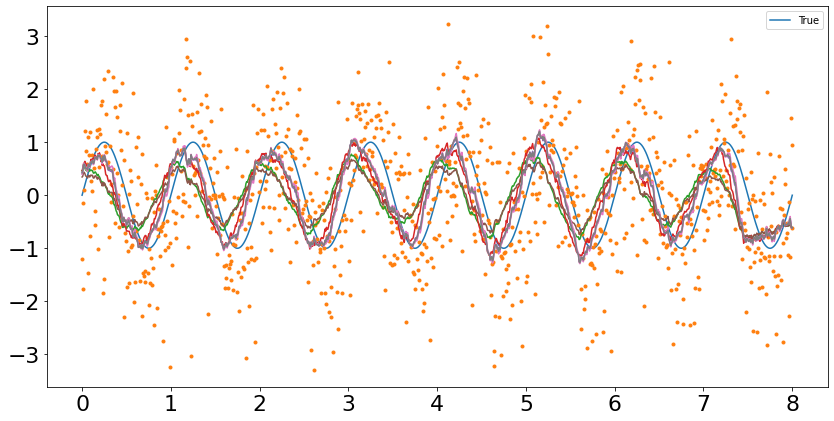

In [50]:
plt.figure(figsize=(14, 7))
plt.plot(x,s, label="True")
plt.plot(x,y,ls='none',marker='.')
# fl = testButterworth(nyf, x, y, s, npts)
# wi = testWiener(x, y, s, npts)
# sp = testSpline(x, y, s, npts)
for kernel in ['gaussian', 'tophat', 'epanechnikov','exponential', 'linear', 'cosine']:
    plt.plot(x, testkernel(x, y, s, npts, kernel, 0.2))
plt.legend(prop={'size': 10})
# plt.savefig("plot.eps")
plt.show()

tophat 0.011408867820171479


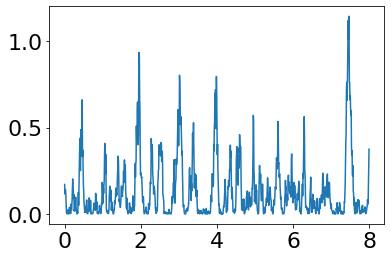

In [66]:
res = testkernel(x, y, s, npts)
plt.plot(x, (res - s) ** 2)
plt.show()

### Real data (Daily temperature Australia)

In [67]:
df = pd.read_csv("daily-min-temperatures.csv")
x_new = np.arange(y_new.shape[0])
y_new = df.Temp.values

In [68]:
res_new = testkernel(x_new, y_new, y_new, 3654)

tophat 0.046269305820229346


gaussian 0.04621195059503017
tophat 0.046269305820229346
epanechnikov 0.045478012952939635
exponential 0.046384670323937165
linear 0.044931499337312206
cosine 0.04539710145432122


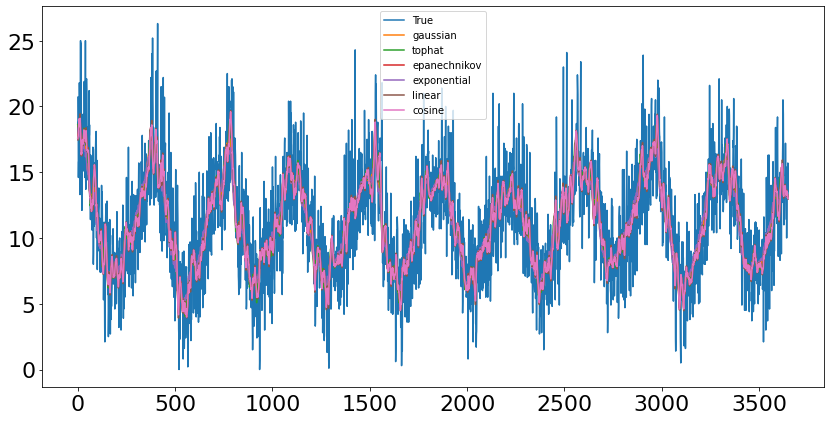

In [75]:
plt.figure(figsize=(14, 7))
plt.plot(x_new, y_new, label="True")
# fl = testButterworth(nyf, x, y, s, npts)
# wi = testWiener(x, y, s, npts)
# sp = testSpline(x, y, s, npts)
for kernel in ['gaussian', 'tophat', 'epanechnikov','exponential', 'linear', 'cosine']:
    plt.plot(x_new, testkernel(x_new, y_new, y_new, 3654, kernel, 0.1), label=kernel)
plt.legend(prop={'size': 10})
# plt.savefig("plot.eps")
plt.show()

tophat 0.046269305820229346


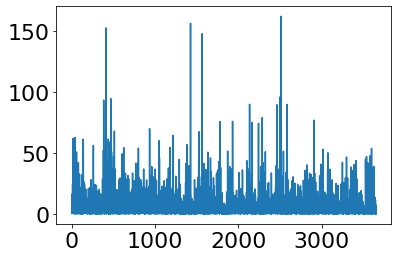

In [78]:
res_new = testkernel(x_new, y_new, y_new, 3654)
plt.plot(x_new, (res_new - y_new)**2)
plt.show()